In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, BatchNormalization, Activation, Embedding, concatenate
from keras.layers import AveragePooling2D, Input, Flatten, Permute, GlobalAveragePooling1D
from keras.layers import TimeDistributed, MaxPooling2D, Dropout, LSTM, ConvLSTM2D, Masking
from keras.applications.xception import Xception
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.utils import plot_model

import sklearn.metrics as metrics
from IPython.display import Image 

import numpy as np
import pandas as pd

import pickle
import sys, gc, os
import glob

import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:
# https://keras.io/examples/cifar10_resnet/
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [3]:
le = LabelEncoder()

train = np.empty(shape=(0,60,256), dtype=np.float32)
labels = np.empty(shape=(0,2), dtype=np.float)

for f in glob.glob("../data/train_lstm1_*"):
    if '_29' not in f:
        print(f)
        train_loader = np.load(f)
        fakes = train_loader['fakes']
        train = np.append(train,fakes,axis=0)
        print('fakes',len(fakes))
        reals = train_loader['reals']
        train = np.append(train,reals,axis=0)
        print('reals',len(reals))
        l = np.append(np.full(len(fakes),'FAKE'),np.full(len(reals),'REAL'))
        l = le.fit_transform(l)
        l = np_utils.to_categorical(l, 2)
        print('labels',labels.ndim,l.ndim)
        labels = np.append(labels,l,axis=0)


print('train=',len(train))
print('labels',len(labels))

../data/train_lstm1_15.npz
fakes 31
reals 31
labels 2 2
../data/train_lstm1_14.npz
fakes 32
reals 31
labels 2 2
../data/train_lstm1_28.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_16.npz
fakes 31
reals 30
labels 2 2
../data/train_lstm1_17.npz
fakes 32
reals 30
labels 2 2
../data/train_lstm1_20.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_34.npz
fakes 30
reals 30
labels 2 2
../data/train_lstm1_35.npz
fakes 31
reals 31
labels 2 2
../data/train_lstm1_21.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_23.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_22.npz
fakes 30
reals 30
labels 2 2
../data/train_lstm1_32.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_26.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_27.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_33.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_25.npz
fakes 31
reals 31
labels 2 2
../data/train_lstm1_31.npz
fakes 32
reals 32
labels 2 2
../data/train_lstm1_19.npz
fakes 32
reals 32
lab

In [4]:
n_steps = 30 * 2 # 30 fps x 2 seconds
n_units = 256 # hidden LSTM units
n_bins = 256 
n_channels = 3
n_classes = 2
batch_size = 32
n_epochs = 50

In [16]:
def lstm1():
    hist_input = Input(shape=(n_steps, n_bins))

#    encoded_hist = LSTM(n_units, return_sequences=True)(hist_input)
#    encoded_hist = LSTM(n_units)(x)

    encoded_hist = ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True)(hist_input)

    output = Dense(n_classes, activation='softmax')(encoded_hist)

    
    model = Model(inputs=hist_input, outputs=output)

    return model

In [17]:
model = lstm1()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

ValueError: Input 0 is incompatible with layer conv_lst_m2d_1: expected ndim=5, found ndim=3

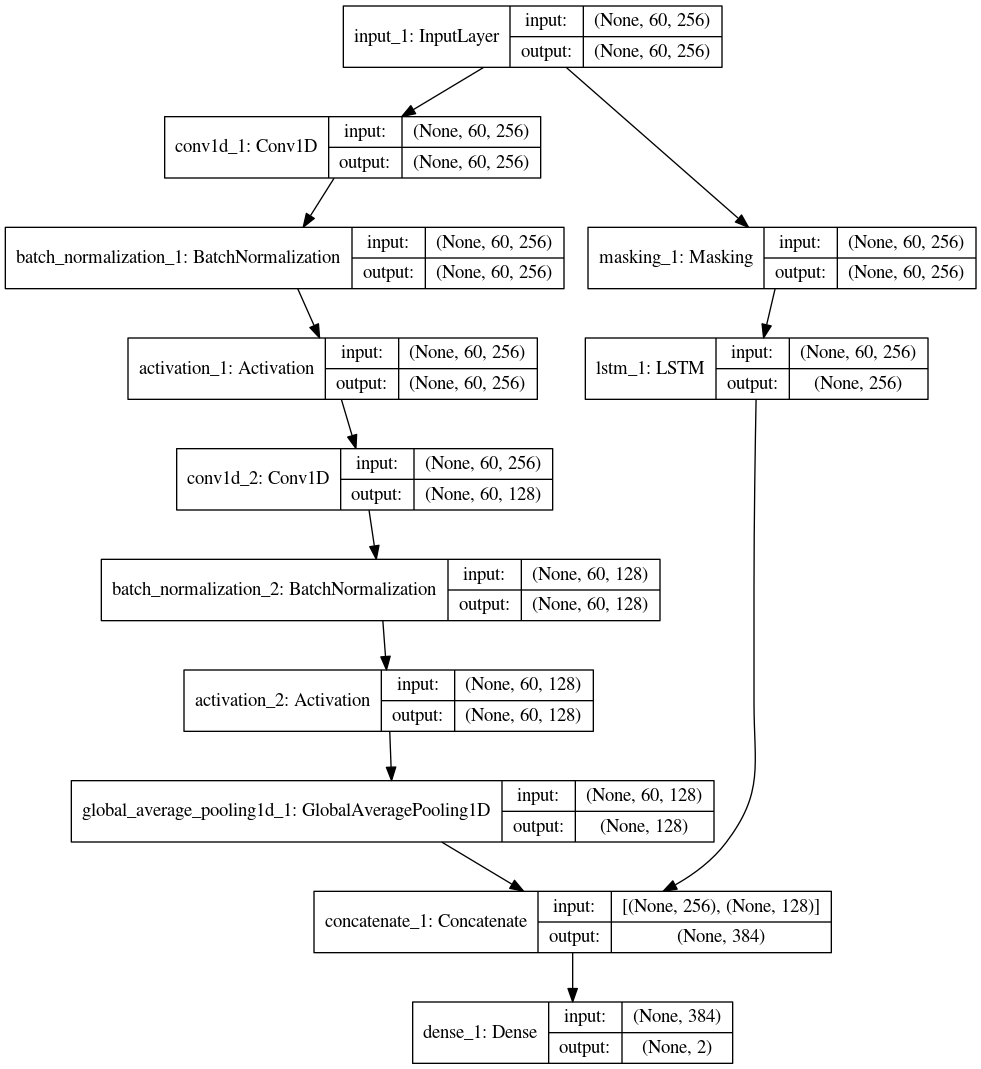

In [7]:
plot_model(model, show_shapes=True, to_file='../models/plot_model.png')
Image('../models/plot_model.png')

In [8]:
# Prepare model model saving directory.
save_dir = '../models'
model_name = 'DDC_LSTM1_model.{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.2,
                               cooldown=0,
                               patience=2,
                               min_lr=0.5e-6)

earlystop = EarlyStopping(monitor='val_loss',
                          patience=10)

callbacks = [checkpoint, lr_reducer, lr_scheduler, earlystop]

In [9]:
(trainX, testX, trainY, testY) = train_test_split(train, labels, test_size=0.25, random_state=42)

In [10]:
# -- del train, labels

In [11]:
history = model.fit(trainX,
              trainY,
              batch_size=batch_size,
              epochs=n_epochs,
              validation_data=(testX, testY),
              shuffle=True,
              callbacks=callbacks)

Train on 992 samples, validate on 331 samples
Epoch 1/50
Learning rate:  0.001
992/992 [==============================] - 7s 7ms/step - loss: 0.7474 - acc: 0.4768 - val_loss: 0.6997 - val_acc: 0.4985

Epoch 00001: val_loss improved from inf to 0.69966, saving model to ../models/DDC_LSTM1_model.001.h5
Epoch 2/50
Learning rate:  0.001
992/992 [==============================] - 5s 5ms/step - loss: 0.7042 - acc: 0.4980 - val_loss: 0.7266 - val_acc: 0.4713

Epoch 00002: val_loss did not improve from 0.69966
Epoch 3/50
Learning rate:  0.001
992/992 [==============================] - 5s 5ms/step - loss: 0.6943 - acc: 0.5131 - val_loss: 0.6990 - val_acc: 0.5076

Epoch 00003: val_loss improved from 0.69966 to 0.69896, saving model to ../models/DDC_LSTM1_model.003.h5
Epoch 4/50
Learning rate:  0.001
992/992 [==============================] - 6s 6ms/step - loss: 0.6969 - acc: 0.5040 - val_loss: 0.7023 - val_acc: 0.4743

Epoch 00004: val_loss did not improve from 0.69896
Epoch 5/50
Learning rate: 

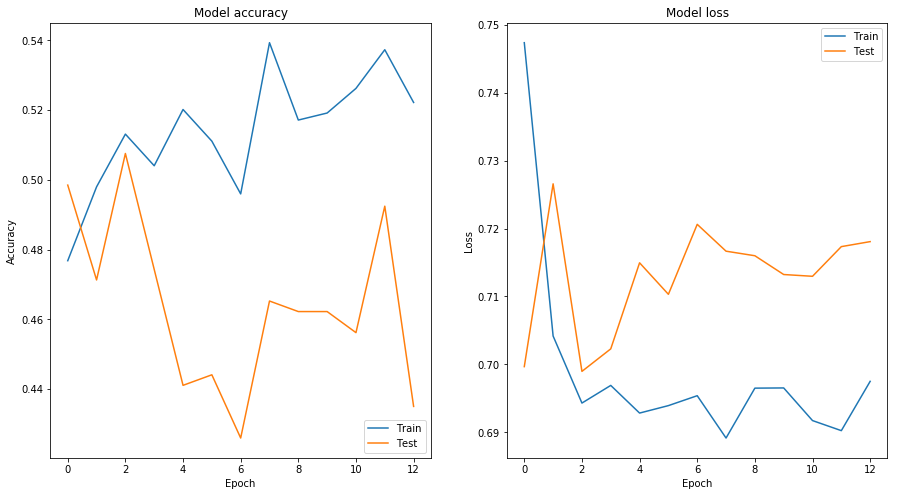

In [12]:
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model accuracy')
ax1.set(xlabel="Epoch", ylabel="Accuracy")
ax1.legend(['Train', 'Test'], loc='lower right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(xlabel="Epoch", ylabel="Loss")
ax2.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [13]:
predictions = model.predict(train)

In [14]:
metrics.log_loss(labels[:,0],predictions[:,0])

0.6949985571878238

In [15]:
predictions

array([[0.5483601 , 0.45163983],
       [0.51461905, 0.48538086],
       [0.5379623 , 0.4620377 ],
       ...,
       [0.5198739 , 0.48012608],
       [0.54320025, 0.45679972],
       [0.52540356, 0.4745964 ]], dtype=float32)